In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import glob
import numpy as np
from PIL import Image
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
import sys
sys.path.append("../")
from inception_resnet_v1 import inference

import seaborn as sns

import traceback

In [2]:
def prewhiten(x):
    """
    A helper function to whiten an image, or a batch of images.
    Args:
        x: An image or batch of images.
    """
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        print(x.ndim)
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
#     std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    """
    Normalizes an embedding to have unit length in the l2 metric.
    Args:
        x: A batch of numpy embeddings
    """
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                           axis=axis,
                                           keepdims=True),
                                    epsilon))
    return output

In [3]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.orig_paths = []
        self.person_name = person_name
        self.clean_embeddings = {}
    
    def _load_one_facenet(self, path, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
    
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        
    def _load_folder_for_facenet(self, folder, resize_size=None):
        paths_list = glob.glob(os.path.join(folder, "*"))
        final_imgs = []
        for img_path in paths_list:
            final_imgs.append(
                self._load_one_facenet(
                    img_path, prewhiten_img=False, resize_size=resize_size))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, mean, std, paths_list
        
    def load_clean_from_folder(self, clean_folder, resize_size=160):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std, self.orig_paths = self._load_folder_for_facenet(
            clean_folder, resize_size=resize_size)
    
    def _undo_preprocess(self, images):
        restored_images = images.copy()
        restored_images  *= self.orig_std
        restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def compute_clean_embeddings_with_model(self, model, model_name):
        self.clean_embeddings[model_name] = self._compute_embeddings(model, self.clean_images)

In [4]:
class MyModel:
    def __init__(self, model_path, inputs=None, sess=None, graph=None):
        if graph is None:
            print("graph is None, creating new graph")
            self.graph = tf.Graph()
        else:
            self.graph = graph
            
        with self.graph.as_default():
            if inputs is None:
                self.model_inputs = tf.placeholder(tf.float32, shape=(None, 160, 160, 3))
            else:
                self.model_inputs = inputs

            vars_before = tf.global_variables()
            self.net, self.endpoints = inference(
                self.model_inputs, keep_probability=1.0, bottleneck_layer_size=512, phase_train=False)
            vars_after = tf.global_variables()

            model_name = dataset_to_model_name["vggface2"]
            model_vars = list(set(vars_after) - set(vars_before))
            model_vars_dict = {}

            curr_scope_name = tf.get_variable_scope().name

            for v in model_vars:
                if v.name.startswith("InceptionResnetV1"):
                    name_without_scope_prefix = v.name[:-2]
                else:
                    name_without_scope_prefix = v.name[len(curr_scope_name)+ 1:-2]

                model_vars_dict[name_without_scope_prefix] = v

            saver = tf.train.Saver(var_list=model_vars_dict)
            
            if sess is None:
                print("sess is None, creating new sess")
                self.sess = tf.Session(graph=graph)
            else:
                self.sess = sess
                
            saver.restore(self.sess, model_path)
                
    
    def predict(self, inputs, batch_size):
        with self.graph.as_default():
            return self.sess.run(self.net, feed_dict={self.model_inputs: inputs})
    
#     def __del__(self):
#         print("deleting model and closing session")
#         print(traceback.print_stack())
#         self.sess.close()

dataset_to_model_name = {
    "casia-webface": "20180408-102900",
    "vggface2": "20180402-114759"
}

dataset_to_ckpt_number = {
    "casia-webface": "90",
    "vggface2": "275"
}

def build_model(dataset_name, inputs=None, sess=None, graph=None):
    model_name = dataset_to_model_name[dataset_name]
    model = MyModel(
        os.path.join(
            "/home/ivan/facenet/models",
            model_name,
            "model-{model_name}.ckpt-{ckpt_num}".format(
                model_name=dataset_to_model_name[dataset_name],
                ckpt_num=dataset_to_ckpt_number[dataset_name]
            )),
        inputs, 
        sess,
        graph
    )
    return model

def build_vggface_model(inputs, sess, graph):
    return build_model("vggface2", inputs, sess, graph)

def build_casiawebface_model(inputs, sess, graph):
    return build_model("casia-webface", inputs, sess, graph)

In [5]:
def path_for_id_clean(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000029/epsilon_0.0/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000958/epsilon_0.0/png".format(id=identity)
    

In [6]:
def build_person(person_name, path_for_id_fn, models_ls, model_names_ls):
    person_a = PersonImages(person_name)
    person_a.load_clean_from_folder(path_for_id_fn(person_a.person_name))
    
    for model, model_name in zip(models_ls, model_names_ls):
        print("Computing embeddings for", person_name, "with model", model_name)
        person_a.compute_clean_embeddings_with_model(model, model_name)
    return person_a

In [7]:
def attack_batch_cw(
    build_model_fn_ls, 
    model_names_ls,
    input_images,
    target_vectors_ls,
    learning_rate,
    epsilon,
    max_iters
):
    input_images = np.array(input_images)
    batch_size, orig_h, orig_w, orig_c = input_images.shape
    
    graph = tf.Graph()
    
    with graph.as_default():
        with tf.Session() as sess:
            images_input_ph = tf.placeholder(
                tf.float32,
                name="input_images",
                shape=input_images.shape
            )
            
            noise_var = tf.get_variable(
                name="adversarial_noise",
                shape=input_images.shape,
                initializer=tf.initializers.truncated_normal(
                    mean=np.mean(input_images),
                    stddev=3 * np.std(input_images)
                )
            )
            sess.run(noise_var.initializer)
            
            images_plus_noise = images_input_ph + noise_var

            randomized_images_plus_noise = tf.image.random_brightness(
                images_plus_noise, 0.5)
        
            randomized_images_plus_noise = tf.image.random_crop(
                randomized_images_plus_noise, 
                [batch_size, orig_h - 10, orig_w - 10, 3]
            )

            randomized_images_plus_noise = tf.image.resize_images(
                randomized_images_plus_noise, [orig_h, orig_w])
            
            randomized_images_plus_noise += tf.random.normal(
                randomized_images_plus_noise.shape, 0.0, 0.75)
            
            randomized_images_plus_noise = tf.clip_by_value(
                randomized_images_plus_noise, input_images - epsilon, input_images + epsilon)
            
            total_loss = 0.0
            for target_vectors, build_model_fn, model_name in zip(
                target_vectors_ls, build_model_fn_ls, model_names_ls):
                                
                with tf.variable_scope(model_name):
                    target_vectors = np.array(target_vectors)
                    print("shape of targets", target_vectors.shape)
                    targets_var = tf.get_variable(
                        name="targets",
                        shape=np.array(target_vectors).shape,
                    )
                    sess.run(tf.assign(targets_var, target_vectors))
                    
                    model = build_model_fn(
                        inputs=randomized_images_plus_noise, 
                        sess=sess,
                        graph=graph
                    )
            
                    model_outputs = tf.nn.l2_normalize(model.net, axis=1)
                    targets = tf.nn.l2_normalize(targets_var, axis=1)
                    loss = tf.losses.cosine_distance(targets, model_outputs, axis=1)
                    total_loss += loss
                print("Loaded model", model_name, "for decoy generation")

            total_loss += 1e-6 * tf.nn.l2_loss(noise_var)
            
            vars_before = set(tf.global_variables())
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(
                total_loss, var_list=[noise_var])
            vars_after = set(tf.global_variables())
            sess.run([v.initializer for v in list(vars_after - vars_before)])
            
            
            losses = []
            for i in range(max_iters):
                loss_value, total_loss_value, _ = sess.run(
                    [loss, total_loss, train_op], feed_dict={images_input_ph: input_images})
                assert not np.isnan(loss_value), "Loss_value is nan"
                losses.append(loss_value)
            
            final_imgs = sess.run(
                tf.clip_by_value(images_plus_noise, input_images - epsilon, input_images + epsilon),
                feed_dict={images_input_ph: input_images}
            )
            
            return final_imgs, losses

In [8]:
def ensemble_generate_decoys_bigger_batches(
    attack_strategy,
    learning_rate,
    epsilon,
    max_iters
):
    model_names = ["vggface2", "casia-webface"]
    model_build_fn_ls = [build_vggface_model, build_casiawebface_model]
    
    built_models_for_embeddings = []
    for model_to_attack in model_names:
        built_models_for_embeddings.append(build_model(model_to_attack))
        
    people_list = [
        build_person(person_name, path_for_id_clean, built_models_for_embeddings, model_names) \
        for person_name in os.listdir("/data/vggface/test_perturbed_sampled")
    ]
    
    for model in built_models_for_embeddings:
        model.sess.close()
    
    print("Done building people objects and computing embeddings.")
    
    for person in tqdm(people_list):
        num, height, width, channels = person.clean_images.shape
        person.adversarial_images = np.zeros((2*(len(people_list) - 1), height, width, channels))
        
        indx = 0
        
        images_to_make_adversarial = []
        targets_for_images = []
        target_vectors_ls = [[], []]
        
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
            
            
            current_chosen_indices = range(indx, indx + 2)
            images_to_make_adversarial.extend(np.take(
                person.clean_images, current_chosen_indices, axis=0))
            
            for indx, model_name in enumerate(model_names):
                target_vector = np.mean(other_person.clean_embeddings[model_name], axis=0)
                target_vectors_ls[indx].extend(np.array([
                    target_vector for _ in range(len(current_chosen_indices))]))
            
            indx += 2
            
        images_to_make_adversarial = np.array(images_to_make_adversarial)
        
        all_adversarial_images, losses =attack_batch_cw(
            model_build_fn_ls, 
            model_names,
            np.array(images_to_make_adversarial),
            target_vectors_ls,
            learning_rate,
            epsilon,
            max_iters
        )
        
            
        fig, ax = plt.subplots()
        ax.plot(range(len(losses)), losses)
        plt.show()
        
        indx = 0
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
            
            save_dest = os.path.join(
                "/data/vggface/test_perturbed_sampled",
                person.person_name,
                "{attack_strategy}_{model}".format(attack_strategy=attack_strategy, model=model_to_attack),
                other_person.person_name
            )
            
            save_path = os.path.join(save_dest, "epsilon_{}".format(epsilon), "png")
            os.makedirs(save_path, exist_ok=True)
            existing_files = os.listdir(save_path)

            # Clean up folder if need be
            if len(existing_files) > 0:
                for f in existing_files:
                    os.remove(os.path.join(save_path, f))
            
            for i in range(indx, indx + 2):
                orig_name = person.orig_paths[i].split("/")[-1]
                person.adversarial_images[i] = all_adversarial_images[i]
                full_save_path = os.path.join(save_path, orig_name)
                print("Saving to", save_path)
                Image.fromarray(
                    person._undo_preprocess(person.adversarial_images[i])
                ).save(full_save_path)

            indx += 2

graph is None, creating new graph
INFO:tensorflow:Scale of 0 disables regularizer.
sess is None, creating new sess
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
graph is None, creating new graph
INFO:tensorflow:Scale of 0 disables regularizer.
sess is None, creating new sess
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Computing embeddings for n001781 with model vggface2
Computing embeddings for n001781 with model casia-webface
Computing embeddings for n009232 with model vggface2
Computing embeddings for n009232 with model casia-webface
Computing embeddings for n000958 with model vggface2
Computing embeddings for n000958 with model casia-webface
Computing embeddings for n003356 with model vggface2
Computing embeddings for n003356 with model casia-webface
Computing embeddings for n008655 with model vggface2
Computing embeddings for n008655 with model 

  0%|          | 0/19 [00:00<?, ?it/s]

Computing embeddings for n009114 with model vggface2
Computing embeddings for n009114 with model casia-webface
Done building people objects and computing embeddings.
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


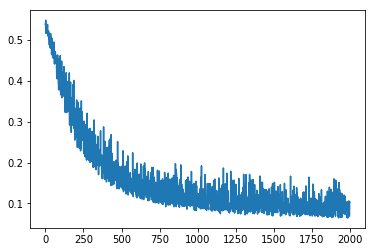

Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n008613/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n008

  5%|▌         | 1/19 [06:23<1:55:02, 383.46s/it]

Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n005303/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n007548/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n007548/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001781/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 

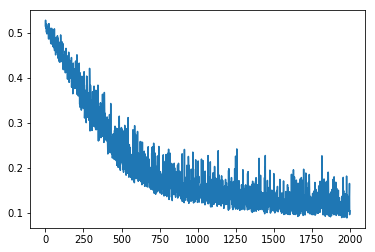

 11%|█         | 2/19 [12:44<1:48:26, 382.73s/it]

Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n008613/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009232/ensemble_casia-webface/n008

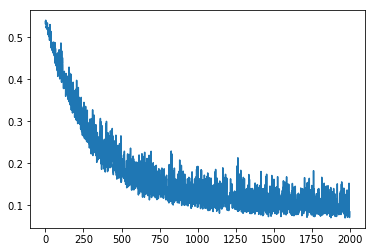

 16%|█▌        | 3/19 [18:59<1:41:27, 380.49s/it]

Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n008613/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000958/ensemble_casia-webface/n008

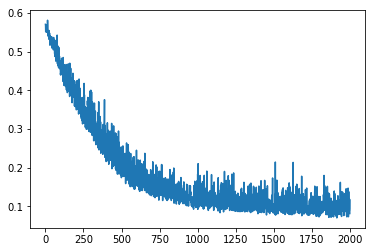

Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n008613/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n008

 21%|██        | 4/19 [25:13<1:34:35, 378.40s/it]

Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n002763/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n002503/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n002503/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n003215/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n003215/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n005359/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n005359/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n005303/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n005303/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003356/ensemble_casia-webface/n007

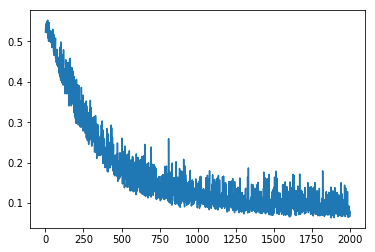

Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n008613/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n008

 26%|██▋       | 5/19 [31:28<1:28:02, 377.34s/it]

Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008655/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


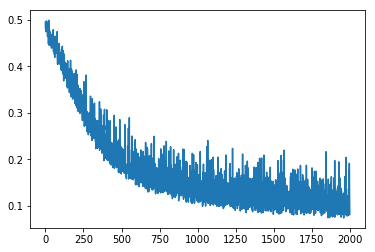

Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n008

 32%|███▏      | 6/19 [37:41<1:21:29, 376.11s/it]

Saving to /data/vggface/test_perturbed_sampled/n008613/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


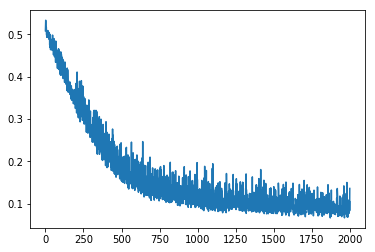

 37%|███▋      | 7/19 [44:03<1:15:33, 377.82s/it]

Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n004658/ensemble_casia-webface/n008

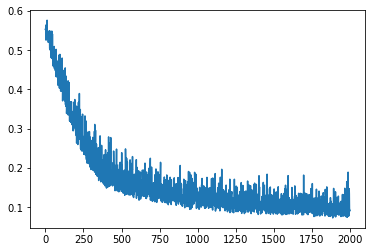

Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n008

 42%|████▏     | 8/19 [50:19<1:09:11, 377.37s/it]

Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n001683/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


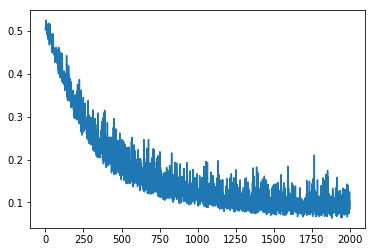

 47%|████▋     | 9/19 [56:38<1:02:57, 377.74s/it]

Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002647/ensemble_casia-webface/n008

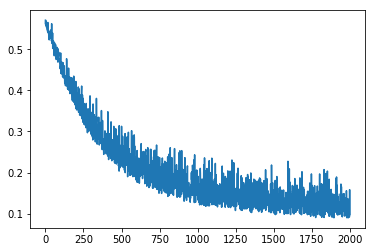

Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n008

 53%|█████▎    | 10/19 [1:02:56<56:41, 377.93s/it]

Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009288/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


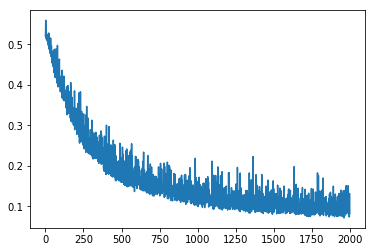

 58%|█████▊    | 11/19 [1:09:17<50:30, 378.87s/it]

Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005427/ensemble_casia-webface/n008

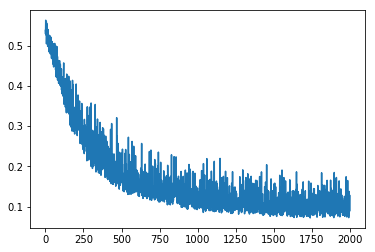

Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n008

 63%|██████▎   | 12/19 [1:15:36<44:12, 378.88s/it]

Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n007548/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002763/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


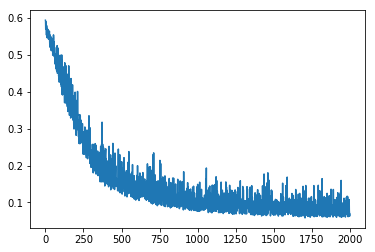

Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n002503/ensemble_casia-webface/n008

 68%|██████▊   | 13/19 [1:21:57<37:56, 379.40s/it]

shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


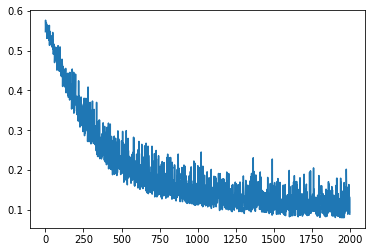

 74%|███████▎  | 14/19 [1:28:14<31:33, 378.73s/it]

Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n003215/ensemble_casia-webface/n008

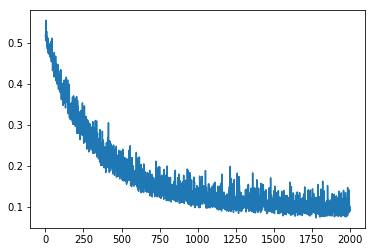

Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n008

 79%|███████▉  | 15/19 [1:34:27<25:07, 376.96s/it]

Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n000029/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n009114/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005359/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


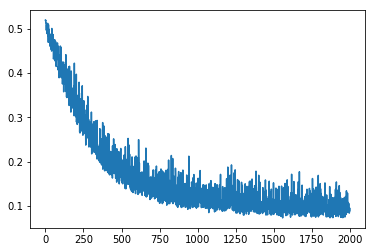

 84%|████████▍ | 16/19 [1:40:40<18:47, 375.86s/it]

Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n005303/ensemble_casia-webface/n008

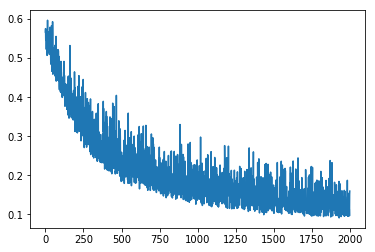

Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n008

 89%|████████▉ | 17/19 [1:46:55<12:31, 375.70s/it]

Saving to /data/vggface/test_perturbed_sampled/n007548/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


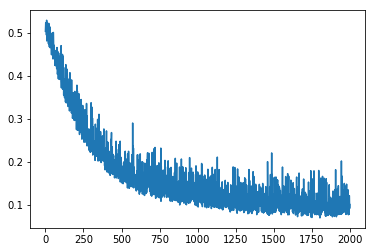

Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n008

 95%|█████████▍| 18/19 [1:53:10<06:15, 375.54s/it]

Saving to /data/vggface/test_perturbed_sampled/n000029/ensemble_casia-webface/n009114/epsilon_0.5/png
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Loaded model vggface2 for decoy generation
shape of targets (36, 512)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
Loaded model casia-webface for decoy generation


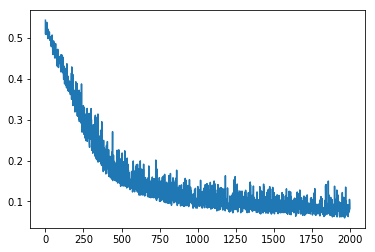

100%|██████████| 19/19 [1:59:28<00:00, 377.31s/it]

Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n001781/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n009232/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n000958/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n003356/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n008655/epsilon_0.5/png
Saving to /data/vggface/test_perturbed_sampled/n009114/ensemble_casia-webface/n008

In [10]:
for epsilon in [0.5]:
    ensemble_generate_decoys_bigger_batches(
        "ensemble",
        0.01,
        epsilon,
        2000
    )